# Predicting Flight Delays with sklearn

In this notebook, we will be using features we've prepared in PySpark to predict flight delays via regression and classification.

In [1]:
import sys, os, re
sys.path.append("lib")
import utils

import numpy as np
import sklearn
import iso8601
import datetime
print("Imports loaded...")

Imports loaded...


## Load and Inspect our JSON Training Data

In [2]:
# Load and check the size of our training data. May take a minute.
print("Original JSON file size: {:,} Bytes".format(os.path.getsize("../data/simple_flight_delay_features.jsonl")))
training_data = utils.read_json_lines_file('../data/simple_flight_delay_features.jsonl')
print("Training items: {:,}".format(len(training_data))) # 5,714,008
print("Data loaded...")

Original JSON file size: 1,676,709,758 Bytes
Training items: 5,714,008
Data loaded...


In [3]:
# Inspect a record before we alter them
print("Size of training data in RAM: {:,} Bytes".format(sys.getsizeof(training_data))) # 50MB
print(training_data[0])

Size of training data in RAM: 50,897,424 Bytes
{'DayOfWeek': 4, 'ArrDelay': 13.0, 'Dest': 'DFW', 'FlightDate': '2014-12-31T16:00:00.000-08:00', 'Carrier': 'AA', 'Distance': 569.0, 'FlightNum': '1024', 'CRSArrTime': '2015-01-01T10:10:00.000-08:00', 'CRSDepTime': '2015-01-01T07:30:00.000-08:00', 'DayOfMonth': 1, 'DayOfYear': 1, 'DepDelay': 14.0, 'Origin': 'ABQ'}


## Sample our Data

In [4]:
# We need to sample our data to fit into RAM
training_data = np.random.choice(training_data, 1000000) # 'Sample down to 1MM examples'
print("Sampled items: {:,} Bytes".format(len(training_data)))
print("Data sampled...")

Sampled items: 1,000,000 Bytes
Data sampled...


## Vectorize the Results (y)

In [5]:
# Separate our results from the rest of the data, vectorize and size up
results = [record['ArrDelay'] for record in training_data]
results_vector = np.array(results)
print("Results vectorized size: {:,}".format(sys.getsizeof(results_vector))) # 45,712,160 bytes
print("Results vectorized...")

Results vectorized size: 8,000,096
Results vectorized...


## Prepare Training Data

In [6]:
# Remove the two delay fields and the flight date from our training data
for item in training_data:
  item.pop('ArrDelay', None)
  item.pop('FlightDate', None)
print("ArrDelay and FlightDate removed from training data...")

ArrDelay and FlightDate removed from training data...


In [7]:
# Must convert datetime strings to unix times
for item in training_data:
  if isinstance(item['CRSArrTime'], str):
    dt = iso8601.parse_date(item['CRSArrTime'])
    unix_time = int(dt.timestamp())
    item['CRSArrTime'] = unix_time
  if isinstance(item['CRSDepTime'], str):
    dt = iso8601.parse_date(item['CRSDepTime'])
    unix_time = int(dt.timestamp())
    item['CRSDepTime'] = unix_time
print("CRSArr/DepTime converted to unix time...")

CRSArr/DepTime converted to unix time...


## Vectorize Training Data with `DictVectorizer`

In [8]:
# Use DictVectorizer to convert feature dicts to vectors
from sklearn.feature_extraction import DictVectorizer

print("Sampled dimensions: [{:,}]".format(len(training_data)))
vectorizer = DictVectorizer()
training_vectors = vectorizer.fit_transform(training_data)
print("Size of DictVectorized vectors: {:,} Bytes".format(training_vectors.data.nbytes))
print("Training data vectorized...")

Sampled dimensions: [1,000,000]
Size of DictVectorized vectors: 87,539,400 Bytes
Training data vectorized...


## Prepare Experiment by Splitting Data into Train/Test

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
  training_vectors,
  results_vector,
  test_size=0.1,
  random_state=43
)
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)
print("Test train split performed...")

(900000, 7436) (100000, 7436)
(900000,) (100000,)
Test train split performed...


## Train our Model(s) on our Training Data

In [10]:
# Train a regressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import median_absolute_error, r2_score
print("Regressor library and metrics imported...")

Regressor library and metrics imported...


In [11]:
regressor = LinearRegression()
print("Regressor instantiated...")

Regressor instantiated...


In [12]:
from sklearn.ensemble import GradientBoostingRegressor

regressor = GradientBoostingRegressor
print("Swapped gradient boosting trees for linear regression!")

# Lets go back for now...
regressor = LinearRegression()
print("Swapped back to linear regression!")

Swapped gradient boosting trees for linear regression!
Swapped back to linear regression!


In [13]:
regressor.fit(X_train, y_train)
print("Regressor fitted...")

Regressor fitted...


## Predict Using the Test Data

In [14]:
predicted = regressor.predict(X_test)
print("Predictions made for X_test...")

Predictions made for X_test...


## Evaluate and Visualize Model Accuracy

In [15]:
from sklearn.metrics import median_absolute_error, r2_score

# Median absolute error is the median of all absolute differences between the target and the prediction.
# Less is better, more indicates a high error between target and prediction.
medae = median_absolute_error(y_test, predicted)
print("Median absolute error:    {:.3g}".format(medae))

# R2 score is the coefficient of determination. Ranges from 1-0, 1.0 is best, 0.0 is worst.
# Measures how well future samples are likely to be predicted.
r2 = r2_score(y_test, predicted)
print("r2 score:                 {:.3g}".format(r2))

Median absolute error:    9.68
r2 score:                 0.828


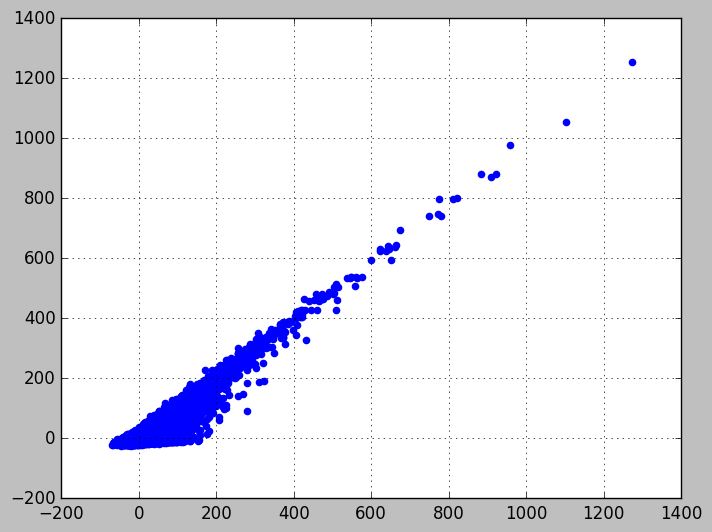

In [111]:
# Plot outputs
import matplotlib.pyplot as plt

# Cleans up the appearance
plt.rcdefaults()

plt.scatter(
  y_test,
  predicted,
  color='blue',
  linewidth=1
)
plt.grid(True)

plt.xticks()
plt.yticks()

plt.show()

explore_delays.py

In [1]:
import findspark
findspark.init()
import pyspark
import pyspark.sql
from pyspark import SparkConf
from pyspark import SparkContext
conf = SparkConf()#
conf.set("spark.python.profile", "true")
#conf = sc.getConf()
conf.set( "spark.driver.memory", "4g" )
conf.set( "spark.jars","/Users/crisliu/agile/lib/mongo-hadoop-spark-2.0.2.jar,\
/Users/crisliu/agile/lib/mongo-java-driver-3.4.0.jar,\
/Users/crisliu/agile/lib/elasticsearch-spark-20_2.10-5.0.0-alpha5.jar,\
/Users/crisliu/agile/lib/snappy-java-1.1.2.6.jar,\
/Users/crisliu/agile/lib/lzo-hadoop-1.0.5.jar")
#/Users/crisliu/agile/lib/elasticsearch-hadoop-5.0.0-alpha5.jar"
#conf.set("spark.executor.extraClassPath","~")
sc = SparkContext('local', 'test', conf=conf)
#sc = pyspark.SparkContext()
APP_NAME = "my_script.py"
spark = pyspark.sql.SparkSession(sc).builder.appName(APP_NAME).getOrCreate()

In [5]:
# Load the on-time parquet file
on_time_dataframe = spark.read.parquet('../data/on_time_performance.parquet')
on_time_dataframe.registerTempTable("on_time_performance")

total_flights = on_time_dataframe.count()
# Flights that were late leaving...
late_departures = on_time_dataframe.filter(on_time_dataframe.DepDelayMinutes > 0)
total_late_departures = late_departures.count()

# Flights that were late arriving...
late_arrivals = on_time_dataframe.filter(on_time_dataframe.ArrDelayMinutes > 0)
total_late_arrivals = late_arrivals.count()

# Flights that left late but made up time to arrive on time...
on_time_heros = on_time_dataframe.filter(
  (on_time_dataframe.DepDelayMinutes > 0)
  &
  (on_time_dataframe.ArrDelayMinutes <= 0)
)
total_on_time_heros = on_time_heros.count()

# Get the percentage of flights that are late, rounded to 1 decimal place
pct_late = round((total_late_arrivals / (total_flights * 1.0)) * 100, 1)

print("Total flights:   {:,}".format(total_flights))
print("Late departures: {:,}".format(total_late_departures))
print("Late arrivals:   {:,}".format(total_late_arrivals))
print("Recoveries:      {:,}".format(total_on_time_heros))
print("Percentage Late: {}%".format(pct_late))

# Get the average minutes late departing and arriving
spark.sql("""
SELECT
  ROUND(AVG(DepDelay),1) AS AvgDepDelay,
  ROUND(AVG(ArrDelay),1) AS AvgArrDelay
FROM on_time_performance
"""
).show()

# Why are flights late? Lets look at some delayed flights and the delay causes
late_flights = spark.sql("""
SELECT
  ArrDelayMinutes,
  WeatherDelay,
  CarrierDelay,
  NASDelay,
  SecurityDelay,
  LateAircraftDelay
FROM
  on_time_performance
WHERE
  WeatherDelay IS NOT NULL
  OR
  CarrierDelay IS NOT NULL
  OR
  NASDelay IS NOT NULL
  OR
  SecurityDelay IS NOT NULL
  OR
  LateAircraftDelay IS NOT NULL
ORDER BY
  FlightDate
""")
late_flights.sample(False, 0.01).show()

Total flights:   5,819,079
Late departures: 2,125,618
Late arrivals:   2,086,896
Recoveries:      606,902
Percentage Late: 35.9%
+-----------+-----------+
|AvgDepDelay|AvgArrDelay|
+-----------+-----------+
|        9.4|        4.4|
+-----------+-----------+

+---------------+------------+------------+--------+-------------+-----------------+
|ArrDelayMinutes|WeatherDelay|CarrierDelay|NASDelay|SecurityDelay|LateAircraftDelay|
+---------------+------------+------------+--------+-------------+-----------------+
|          276.0|         0.0|         0.0|     0.0|          0.0|            276.0|
|           17.0|         0.0|         0.0|    17.0|          0.0|              0.0|
|           16.0|         0.0|         0.0|    16.0|          0.0|              0.0|
|           23.0|         0.0|         0.0|     0.0|          0.0|             23.0|
|          170.0|         0.0|       170.0|     0.0|          0.0|              0.0|
|          112.0|         0.0|        50.0|     6.0|        

In [ ]:
# Calculate the percentage contribution to delay for each source
total_delays = spark.sql("""
SELECT
  ROUND(SUM(WeatherDelay)/SUM(ArrDelayMinutes) * 100, 1) AS pct_weather_delay,
  ROUND(SUM(CarrierDelay)/SUM(ArrDelayMinutes) * 100, 1) AS pct_carrier_delay,
  ROUND(SUM(NASDelay)/SUM(ArrDelayMinutes) * 100, 1) AS pct_nas_delay,
  ROUND(SUM(SecurityDelay)/SUM(ArrDelayMinutes) * 100, 1) AS pct_security_delay,
  ROUND(SUM(LateAircraftDelay)/SUM(ArrDelayMinutes) * 100, 1) AS pct_late_aircraft_delay
FROM on_time_performance
""")
total_delays.show()

# Generate a histogram of the weather and carrier delays
weather_delay_histogram = on_time_dataframe\
  .select("WeatherDelay")\
  .rdd\
  .flatMap(lambda x: x)\
  .histogram(10)

print("{}\n{}".format(weather_delay_histogram[0], weather_delay_histogram[1]))

# Eyeball the first to define our buckets
weather_delay_histogram = on_time_dataframe\
  .select("WeatherDelay")\
  .rdd\
  .flatMap(lambda x: x)\
  .histogram([1, 15, 30, 60, 120, 240, 480, 720, 24*60.0])
print(weather_delay_histogram)

# Transform the data into something easily consumed by d3
record = {'key': 1, 'data': []}
for label, count in zip(weather_delay_histogram[0], weather_delay_histogram[1]):
  record['data'].append(
    {
      'label': label,
      'count': count
    }
  )

In [7]:
# Save to Mongo directly, since this is a Tuple not a dataframe or RDD
from pymongo import MongoClient
client = MongoClient()
client.relato.weather_delay_histogram.insert_one(record)

# Transform the data into something easily consumed by d3
def histogram_to_publishable(histogram):
  record = {'key': 1, 'data': []}
  for label, value in zip(histogram[0], histogram[1]):
    record['data'].append(
      {
        'label': label,
        'value': value
      }
    )
  return record

# Recompute the weather histogram with a filter for on-time flights
weather_delay_histogram = on_time_dataframe\
  .filter(
    (on_time_dataframe.WeatherDelay != None)
    &
    (on_time_dataframe.WeatherDelay > 0)
  )\
  .select("WeatherDelay")\
  .rdd\
  .flatMap(lambda x: x)\
  .histogram([0, 15, 30, 60, 120, 240, 480, 720, 24*60.0])
print(weather_delay_histogram)

record = histogram_to_publishable(weather_delay_histogram)
# Get rid of the old stuff and put the new stuff in its place
client.relato.weather_delay_histogram.drop()
client.relato.weather_delay_histogram.insert_one(record)

TypeError: 'Collection' object is not callable. If you meant to call the 'insert_one' method on a 'Database' object it is failing because no such method exists.

extract_features.py

In [18]:
import sys, os, re
import iso8601
import datetime

# Select a few features of interest
simple_on_time_features = spark.sql("""
SELECT
  FlightNum,
  FlightDate,
  DayOfWeek,
  DayofMonth AS DayOfMonth,
  CONCAT(Month, '-',  DayofMonth) AS DayOfYear,
  Carrier,
  Origin,
  Dest,
  Distance,
  DepDelay,
  ArrDelay,
  CRSDepTime,
  CRSArrTime
FROM on_time_performance
""")
simple_on_time_features.show()

# Filter nulls, they can't help us
filled_on_time_features = simple_on_time_features.filter(
  simple_on_time_features.ArrDelay.isNotNull()
  &
  simple_on_time_features.DepDelay.isNotNull()
)

# We need to turn timestamps into timestamps, and not strings or numbers
def convert_hours(hours_minutes):
  hours = hours_minutes[:-2]
  minutes = hours_minutes[-2:]
  
  if hours == '24':
    hours = '23'
    minutes = '59'
  
  time_string = "{}:{}:00Z".format(hours, minutes)
  return time_string

def compose_datetime(iso_date, time_string):
  return "{} {}".format(iso_date, time_string)

def create_iso_string(iso_date, hours_minutes):
  time_string = convert_hours(hours_minutes)
  full_datetime = compose_datetime(iso_date, time_string)
  return full_datetime

def create_datetime(iso_string):
  return iso8601.parse_date(iso_string)

def convert_datetime(iso_date, hours_minutes):
  iso_string = create_iso_string(iso_date, hours_minutes)
  dt = create_datetime(iso_string)
  return dt

def day_of_year(iso_date_string):
  dt = iso8601.parse_date(iso_date_string)
  doy = dt.timetuple().tm_yday
  return doy

def alter_feature_datetimes(row):
  
  flight_date = iso8601.parse_date(row['FlightDate'])
  scheduled_dep_time = convert_datetime(row['FlightDate'], row['CRSDepTime'])
  scheduled_arr_time = convert_datetime(row['FlightDate'], row['CRSArrTime'])
  
  # Handle overnight flights
  if scheduled_arr_time < scheduled_dep_time:
    scheduled_arr_time += datetime.timedelta(days=1)
  
  doy = day_of_year(row['FlightDate'])
  
  return {
    'FlightNum': row['FlightNum'],
    'FlightDate': flight_date,
    'DayOfWeek': int(row['DayOfWeek']),
    'DayOfMonth': int(row['DayOfMonth']),
    'DayOfYear': doy,
    'Carrier': row['Carrier'],
    'Origin': row['Origin'],
    'Dest': row['Dest'],
    'Distance': row['Distance'],
    'DepDelay': row['DepDelay'],
    'ArrDelay': row['ArrDelay'],
    'CRSDepTime': scheduled_dep_time,
    'CRSArrTime': scheduled_arr_time,
  }

timestamp_features = filled_on_time_features.rdd.map(alter_feature_datetimes)
timestamp_df = timestamp_features.toDF()

# Explicitly sort the data and keep it sorted throughout. Leave nothing to chance.
sorted_features = timestamp_df.sort(
  timestamp_df.DayOfYear,
  timestamp_df.Carrier,
  timestamp_df.Origin,
  timestamp_df.Dest,
  timestamp_df.FlightNum,
  timestamp_df.CRSDepTime,
  timestamp_df.CRSArrTime,
)

+---------+----------+---------+----------+---------+-------+------+----+--------+--------+--------+----------+----------+
|FlightNum|FlightDate|DayOfWeek|DayOfMonth|DayOfYear|Carrier|Origin|Dest|Distance|DepDelay|ArrDelay|CRSDepTime|CRSArrTime|
+---------+----------+---------+----------+---------+-------+------+----+--------+--------+--------+----------+----------+
|     1519|2015-01-01|        4|         1|      1-1|     AA|   DFW| MEM|   432.0|    -3.0|    -6.0|      1345|      1510|
|     1519|2015-01-01|        4|         1|      1-1|     AA|   MEM| DFW|   432.0|    -4.0|    -9.0|      1550|      1730|
|     2349|2015-01-01|        4|         1|      1-1|     AA|   ORD| DFW|   802.0|     0.0|    26.0|      1845|      2115|
|     1298|2015-01-01|        4|         1|      1-1|     AA|   DFW| ATL|   731.0|   100.0|   112.0|      1820|      2120|
|     1422|2015-01-01|        4|         1|      1-1|     AA|   DFW| HDN|   769.0|    78.0|    78.0|      0800|      0925|
|     1422|2015-

/Users/crisliu/agile/spark/python/pyspark/sql/session.py:336: UserWarning: Using RDD of dict to inferSchema is deprecated. Use pyspark.sql.Row instead
  warnings.warn("Using RDD of dict to inferSchema is deprecated. "


In [19]:
# Store as a single json file and bzip2 it
sorted_features.repartition(1).write.mode("overwrite").json("../data/simple_flight_delay_features.json")
os.system("cp ../data/simple_flight_delay_features.json/part* ../data/simple_flight_delay_features.jsonl")
os.system("bzip2 --best ../data/simple_flight_delay_features.jsonl")
os.system("bzcat ../data/simple_flight_delay_features.jsonl.bz2 >> ../data/simple_flight_delay_features.jsonl")

0

In [22]:
!bzcat ../data/simple_flight_delay_features.jsonl.bz2 | head -5

{"ArrDelay":13.0,"CRSArrTime":"2015-01-01T13:10:00.000-05:00","CRSDepTime":"2015-01-01T10:30:00.000-05:00","Carrier":"AA","DayOfMonth":1,"DayOfWeek":4,"DayOfYear":1,"DepDelay":14.0,"Dest":"DFW","Distance":569.0,"FlightDate":"2014-12-31T19:00:00.000-05:00","FlightNum":"1024","Origin":"ABQ"}
{"ArrDelay":17.0,"CRSArrTime":"2015-01-01T05:15:00.000-05:00","CRSDepTime":"2015-01-01T02:25:00.000-05:00","Carrier":"AA","DayOfMonth":1,"DayOfWeek":4,"DayOfYear":1,"DepDelay":14.0,"Dest":"DFW","Distance":569.0,"FlightDate":"2014-12-31T19:00:00.000-05:00","FlightNum":"1184","Origin":"ABQ"}
{"ArrDelay":36.0,"CRSArrTime":"2015-01-01T06:45:00.000-05:00","CRSDepTime":"2015-01-01T04:00:00.000-05:00","Carrier":"AA","DayOfMonth":1,"DayOfWeek":4,"DayOfYear":1,"DepDelay":-2.0,"Dest":"DFW","Distance":569.0,"FlightDate":"2014-12-31T19:00:00.000-05:00","FlightNum":"336","Origin":"ABQ"}
{"ArrDelay":-21.0,"CRSArrTime":"2015-01-01T14:30:00.000-05:00","CRSDepTime":"2015-01-01T12:55:00.000-05:00","Carrier":"AA","DayO

train_spark_mllib_model.py

In [24]:
#
# {
#   "ArrDelay":5.0,"CRSArrTime":"2015-12-31T03:20:00.000-08:00","CRSDepTime":"2015-12-31T03:05:00.000-08:00",
#   "Carrier":"WN","DayOfMonth":31,"DayOfWeek":4,"DayOfYear":365,"DepDelay":14.0,"Dest":"SAN","Distance":368.0,
#   "FlightDate":"2015-12-30T16:00:00.000-08:00","FlightNum":"6109","Origin":"TUS"
# }
#
from pyspark.sql.types import StringType, IntegerType, FloatType, DoubleType, DateType, TimestampType
from pyspark.sql.types import StructType, StructField
from pyspark.sql.functions import udf

schema = StructType([
  StructField("ArrDelay", DoubleType(), True),     # "ArrDelay":5.0
  StructField("CRSArrTime", TimestampType(), True),    # "CRSArrTime":"2015-12-31T03:20:00.000-08:00"
  StructField("CRSDepTime", TimestampType(), True),    # "CRSDepTime":"2015-12-31T03:05:00.000-08:00"
  StructField("Carrier", StringType(), True),     # "Carrier":"WN"
  StructField("DayOfMonth", IntegerType(), True), # "DayOfMonth":31
  StructField("DayOfWeek", IntegerType(), True),  # "DayOfWeek":4
  StructField("DayOfYear", IntegerType(), True),  # "DayOfYear":365
  StructField("DepDelay", DoubleType(), True),     # "DepDelay":14.0
  StructField("Dest", StringType(), True),        # "Dest":"SAN"
  StructField("Distance", DoubleType(), True),     # "Distance":368.0
  StructField("FlightDate", DateType(), True),    # "FlightDate":"2015-12-30T16:00:00.000-08:00"
  StructField("FlightNum", StringType(), True),   # "FlightNum":"6109"
  StructField("Origin", StringType(), True),      # "Origin":"TUS"
])

features = spark.read.json(
  "../data/simple_flight_delay_features.jsonl.bz2",
  schema=schema
)
features.first()

Row(ArrDelay=13.0, CRSArrTime=datetime.datetime(2015, 1, 1, 13, 10), CRSDepTime=datetime.datetime(2015, 1, 1, 10, 30), Carrier='AA', DayOfMonth=1, DayOfWeek=4, DayOfYear=1, DepDelay=14.0, Dest='DFW', Distance=569.0, FlightDate=datetime.date(2014, 12, 31), FlightNum='1024', Origin='ABQ')

In [25]:
#
# Check for nulls in features before using Spark ML
#
null_counts = [(column, features.where(features[column].isNull()).count()) for column in features.columns]
cols_with_nulls = filter(lambda x: x[1] > 0, null_counts)
print(list(cols_with_nulls))

#
# Add a Route variable to replace FlightNum
#
from pyspark.sql.functions import lit, concat

features_with_route = features.withColumn(
  'Route',
  concat(
    features.Origin,
    lit('-'),
    features.Dest
  )
)
features_with_route.select("Origin", "Dest", "Route").show(5)

[]
+------+----+-------+
|Origin|Dest|  Route|
+------+----+-------+
|   ABQ| DFW|ABQ-DFW|
|   ABQ| DFW|ABQ-DFW|
|   ABQ| DFW|ABQ-DFW|
|   ATL| DFW|ATL-DFW|
|   ATL| DFW|ATL-DFW|
+------+----+-------+
only showing top 5 rows



In [26]:
#
# Categorize or 'bucketize' the arrival delay field using a DataFrame UDF
#
def bucketize_arr_delay(arr_delay):
  bucket = None
  if arr_delay <= -15.0:
    bucket = 0.0
  elif arr_delay > -15.0 and arr_delay <= 0.0:
    bucket = 1.0
  elif arr_delay > 0.0 and arr_delay <= 30.0:
    bucket = 2.0
  elif arr_delay > 30.0:
    bucket = 3.0
  return bucket

# Wrap the function in pyspark.sql.functions.udf with...
# pyspark.sql.types.StructField information
dummy_function_udf = udf(bucketize_arr_delay, StringType())

# Add a category column via pyspark.sql.DataFrame.withColumn
manual_bucketized_features = features_with_route.withColumn(
  "ArrDelayBucket",
  dummy_function_udf(features['ArrDelay'])
)
manual_bucketized_features.select("ArrDelay", "ArrDelayBucket").show()

#
# Use pysmark.ml.feature.Bucketizer to bucketize ArrDelay
#
from pyspark.ml.feature import Bucketizer

splits = [-float("inf"), -15.0, 0, 30.0, float("inf")]
bucketizer = Bucketizer(
  splits=splits,
  inputCol="ArrDelay",
  outputCol="ArrDelayBucket"
)
ml_bucketized_features = bucketizer.transform(features_with_route)

# Check the buckets out
ml_bucketized_features.select("ArrDelay", "ArrDelayBucket").show()

+--------+--------------+
|ArrDelay|ArrDelayBucket|
+--------+--------------+
|    13.0|           2.0|
|    17.0|           2.0|
|    36.0|           3.0|
|   -21.0|           0.0|
|   -14.0|           1.0|
|    16.0|           2.0|
|    -7.0|           1.0|
|    13.0|           2.0|
|    25.0|           2.0|
|    58.0|           3.0|
|    14.0|           2.0|
|     1.0|           2.0|
|   -29.0|           0.0|
|   -10.0|           1.0|
|    -3.0|           1.0|
|    -8.0|           1.0|
|    -1.0|           1.0|
|   -14.0|           1.0|
|   -16.0|           0.0|
|    18.0|           2.0|
+--------+--------------+
only showing top 20 rows

+--------+--------------+
|ArrDelay|ArrDelayBucket|
+--------+--------------+
|    13.0|           2.0|
|    17.0|           2.0|
|    36.0|           3.0|
|   -21.0|           0.0|
|   -14.0|           1.0|
|    16.0|           2.0|
|    -7.0|           1.0|
|    13.0|           2.0|
|    25.0|           2.0|
|    58.0|           3.0|
|    14.0|  

In [27]:
#
# Extract features tools in with pyspark.ml.feature
#
from pyspark.ml.feature import StringIndexer, VectorAssembler

# Turn category fields into categoric feature vectors, then drop intermediate fields
for column in ["Carrier", "DayOfMonth", "DayOfWeek", "DayOfYear",
               "Origin", "Dest", "Route"]:
  string_indexer = StringIndexer(
    inputCol=column,
    outputCol=column + "_index"
  )
  ml_bucketized_features = string_indexer.fit(ml_bucketized_features)\
                                          .transform(ml_bucketized_features)

# Check out the indexes
ml_bucketized_features.show(6)

# Handle continuous, numeric fields by combining them into one feature vector
numeric_columns = ["DepDelay", "Distance"]
index_columns = ["Carrier_index", "DayOfMonth_index",
                   "DayOfWeek_index", "DayOfYear_index", "Origin_index",
                   "Origin_index", "Dest_index", "Route_index"]
vector_assembler = VectorAssembler(
  inputCols=numeric_columns + index_columns,
  outputCol="Features_vec"
)
final_vectorized_features = vector_assembler.transform(ml_bucketized_features)

# Drop the index columns
for column in index_columns:
  final_vectorized_features = final_vectorized_features.drop(column)

# Check out the features
final_vectorized_features.show()

+--------+--------------------+--------------------+-------+----------+---------+---------+--------+----+--------+----------+---------+------+-------+--------------+-------------+----------------+---------------+---------------+------------+----------+-----------+
|ArrDelay|          CRSArrTime|          CRSDepTime|Carrier|DayOfMonth|DayOfWeek|DayOfYear|DepDelay|Dest|Distance|FlightDate|FlightNum|Origin|  Route|ArrDelayBucket|Carrier_index|DayOfMonth_index|DayOfWeek_index|DayOfYear_index|Origin_index|Dest_index|Route_index|
+--------+--------------------+--------------------+-------+----------+---------+---------+--------+----+--------+----------+---------+------+-------+--------------+-------------+----------------+---------------+---------------+------------+----------+-----------+
|    13.0|2015-01-01 13:10:...|2015-01-01 10:30:...|     AA|         1|        4|        1|    14.0| DFW|   569.0|2014-12-31|     1024|   ABQ|ABQ-DFW|           2.0|          2.0|            25.0|         

In [28]:
#
# Cross validate, train and evaluate classifier
#

# Test/train split
training_data, test_data = final_vectorized_features.randomSplit([0.7, 0.3])

# Instantiate and fit random forest classifier
from pyspark.ml.classification import RandomForestClassifier
rfc = RandomForestClassifier(
  featuresCol="Features_vec",
  labelCol="ArrDelayBucket",
  maxBins=4657,
  maxMemoryInMB=1024
)
model = rfc.fit(training_data)

# Evaluate model using test data
predictions = model.transform(test_data)

from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(labelCol="ArrDelayBucket", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Accuracy = {}".format(accuracy))

# Check a sample
predictions.sample(False, 0.001, 18).orderBy("CRSDepTime").show(6)

Accuracy = 0.5965066103374793
+--------+--------------------+--------------------+-------+----------+---------+---------+--------+----+--------+----------+---------+------+-------+--------------+--------------------+--------------------+--------------------+----------+
|ArrDelay|          CRSArrTime|          CRSDepTime|Carrier|DayOfMonth|DayOfWeek|DayOfYear|DepDelay|Dest|Distance|FlightDate|FlightNum|Origin|  Route|ArrDelayBucket|        Features_vec|       rawPrediction|         probability|prediction|
+--------+--------------------+--------------------+-------+----------+---------+---------+--------+----+--------+----------+---------+------+-------+--------------+--------------------+--------------------+--------------------+----------+
|   -15.0|2015-01-01 09:00:...|2015-01-01 05:10:...|     AA|         1|        4|        1|    -3.0| PBI|  1144.0|2014-12-31|     2246|   ORD|ORD-PBI|           1.0|[-3.0,1144.0,2.0,...|[6.43938790572750...|[0.32196939528637...|       1.0|
|     3.0|